In [1]:
#import packages
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import itertools
from networkx.algorithms import community
import operator
from itertools import islice
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_predict
from imblearn.over_sampling import SVMSMOTE
from sklearn.model_selection import cross_validate
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import category_encoders as ce
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB 
from sklearn.naive_bayes import BernoulliNB

In [79]:
#load dataset
tdf = pd.read_excel('/Scripts/world_transfers/fin_train_df.xlsx')

#drop the randomly created column
tdf = tdf.drop('Unnamed: 0', 1)


In [58]:
tdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17431 entries, 0 to 17430
Data columns (total 63 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   NewName           17431 non-null  object 
 1   MarketValue       17431 non-null  float64
 2   ClubInvolved      17430 non-null  object 
 3   League            17431 non-null  object 
 4   MainPosition      17431 non-null  object 
 5   LeagueInvolved    17431 non-null  object 
 6   CorrMarketValue   17431 non-null  float64
 7   ID                17431 non-null  int64  
 8   Name              17431 non-null  object 
 9   Age               17431 non-null  int64  
 10  Height_cm         17431 non-null  object 
 11  Weight_kg         17431 non-null  object 
 12  Country           17431 non-null  object 
 13  Club              17431 non-null  object 
 14  Joined            12994 non-null  object 
 15  Position          17431 non-null  object 
 16  Foot              17431 non-null  object

In [80]:
tdf['target'] = 0
#tdf.loc[tdf.League == 'English Premier League', 'target'] = 1
tdf.loc[tdf.League == 'Spain Primera Division', 'target'] = 1
#tdf.loc[tdf.League == 'Italian Serie A', 'target'] = 1
#tdf.loc[tdf.League == 'French Ligue 1', 'target'] = 1
#tdf.loc[tdf.League == 'German 1 Bundesliga', 'target'] = 1
tdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17431 entries, 0 to 17430
Data columns (total 64 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   NewName           17431 non-null  object 
 1   MarketValue       17431 non-null  float64
 2   ClubInvolved      17430 non-null  object 
 3   League            17431 non-null  object 
 4   MainPosition      17431 non-null  object 
 5   LeagueInvolved    17431 non-null  object 
 6   CorrMarketValue   17431 non-null  float64
 7   ID                17431 non-null  int64  
 8   Name              17431 non-null  object 
 9   Age               17431 non-null  int64  
 10  Height_cm         17431 non-null  object 
 11  Weight_kg         17431 non-null  object 
 12  Country           17431 non-null  object 
 13  Club              17431 non-null  object 
 14  Joined            12994 non-null  object 
 15  Position          17431 non-null  object 
 16  Foot              17431 non-null  object

In [81]:
tdf = tdf.drop(['NewName', 'ClubInvolved', 'League', 'MainPosition', 'MarketValue',\
     'ID', 'Name', 'Height_cm', 'Weight_kg', 'Club', 'Joined', 'Value',\
     'Wage', 'Season', 'Eigv'], axis = 1)

In [82]:
tdf['target'].value_counts()

0    16249
1     1182
Name: target, dtype: int64

In [83]:
#set feature list and target
feature_list = list(tdf.columns.values)
feature_list.remove('target')
target = 'target'

# define dataset
X = tdf[feature_list]
y = tdf[target]

In [84]:
#encoding the categorival variables using target encoding
cbe_encoder = ce.cat_boost.CatBoostEncoder()
X_cbe = cbe_encoder.fit_transform(X,y)
X_cbe

,LeagueInvolved,CorrMarketValue,Age,Country,Position,Foot,IntReputation,Crossing,Finishing,Heading_accuracy,...,GK_kicking,GK_positioning,GK_reflexes,Years,DEGREE,SP_LA_LIGA,EN_PL,IT_SERIE_A,FR_LIGUE_1,GE_BUNDESLIGA
0,0.067810,5.00,20,0.067810,0.067810,0.067810,1,78,73,58,...,12,9,11,2,7,0,0,0,0,0
1,0.033905,2.50,20,0.033905,0.067810,0.067810,1,66,74,54,...,14,10,14,2,0,0,0,0,0,0
2,0.022603,5.00,21,0.022603,0.067810,0.033905,1,62,65,62,...,12,7,5,2,3,0,0,0,0,0
3,0.016953,5.00,21,0.016953,0.033905,0.022603,1,62,65,62,...,12,7,5,2,3,0,0,0,0,0
4,0.013562,4.00,21,0.013562,0.067810,0.033905,1,72,69,57,...,11,9,12,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17426,0.036127,0.32,23,0.013605,0.056397,0.065118,1,62,69,67,...,15,15,9,5,10,0,0,0,0,5
17427,0.002810,0.12,23,0.009305,0.061035,0.065113,1,32,18,65,...,15,7,11,2,25,0,15,0,0,10
17428,0.002803,0.08,17,0.009295,0.061016,0.065108,1,28,21,59,...,8,12,15,2,0,0,0,0,0,0
17429,0.002795,0.30,25,0.009284,0.080837,0.076115,1,68,45,58,...,13,13,13,1,19,0,0,0,0,15


In [85]:
#Impute missing values
imputer = IterativeImputer()
imputer.fit(X_cbe)
X_imp = imputer.transform(X_cbe)
X_imp = pd.DataFrame(data = X_imp, columns = X_cbe.columns)
X_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17431 entries, 0 to 17430
Data columns (total 48 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   LeagueInvolved    17431 non-null  float64
 1   CorrMarketValue   17431 non-null  float64
 2   Age               17431 non-null  float64
 3   Country           17431 non-null  float64
 4   Position          17431 non-null  float64
 5   Foot              17431 non-null  float64
 6   IntReputation     17431 non-null  float64
 7   Crossing          17431 non-null  float64
 8   Finishing         17431 non-null  float64
 9   Heading_accuracy  17431 non-null  float64
 10  Short_passing     17431 non-null  float64
 11  Volleys           17431 non-null  float64
 12  Dribbling         17431 non-null  float64
 13  Curve             17431 non-null  float64
 14  FK_accuracy       17431 non-null  float64
 15  Long_passing      17431 non-null  float64
 16  Ball_control      17431 non-null  float6

In [86]:
#standardization 
scaler = StandardScaler()
X_imp_st = scaler.fit_transform(X_imp)
X_imp_st = pd.DataFrame(data = X_imp_st, columns=X_imp.columns)

Test different models

In [104]:
# define the model
model = GradientBoostingClassifier(n_estimators=50)

# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)

#scoring params
scoring = {'acc': 'accuracy',
           'recall': 'recall',
           'auc': 'roc_auc'}

# evaluate the model on the dataset
n_scores = cross_validate(model, X_imp_st, y, scoring=scoring, cv=cv, n_jobs=-1, return_train_score= False)

# report performance
for key, value in n_scores.items():
    print(key, mean(value))

fit_time 11.83364384174347
score_time 0.031321048736572266
test_acc 0.9234698624116389
test_recall 0.25236434733532204
test_auc 0.898659509078494


In [119]:
# define the model
model = AdaBoostClassifier(n_estimators=50)

# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)

#scoring params
scoring = {'acc': 'accuracy',
           'recall': 'recall',
           'auc': 'roc_auc'}

# evaluate the model on the dataset
n_scores = cross_validate(model, X_imp_st, y, scoring=scoring, cv=cv, n_jobs=-1, return_train_score= False)

# report performance
for key, value in n_scores.items():
    print(key, mean(value))

fit_time 8.733794414997101
score_time 0.25274202823638914
test_acc 0.9199130236542501
test_recall 0.3172740466016286
test_auc 0.8911522592899956


In [49]:
# define the model
model = XGBClassifier(n_estimators=50)

# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)

#scoring params
scoring = {'acc': 'accuracy',
           'recall': 'recall',
           'auc': 'roc_auc'}

# evaluate the model on the dataset
n_scores = cross_validate(model, X_imp_st, y, scoring=scoring, cv=cv, n_jobs=-1, return_train_score= False)

# report performance
for key, value in n_scores.items():
    print(key, mean(value))

fit_time 17.502425491809845
score_time 0.09470688104629517
test_acc 0.9264530763947005
test_recall 0.3654136096105781
test_auc 0.9066554245711682


In [121]:
# define the model
model = RandomForestClassifier(n_estimators=50)

# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)

#scoring params
scoring = {'acc': 'accuracy',
           'recall': 'recall',
           'auc': 'roc_auc'}

# evaluate the model on the dataset
n_scores = cross_validate(model, X_imp_st, y, scoring=scoring, cv=cv, n_jobs=-1, return_train_score= False)

# report performance
for key, value in n_scores.items():
    print(key, mean(value))

fit_time 10.116764390468598
score_time 0.23379260301589966
test_acc 0.9262234718691278
test_recall 0.27103523341127145
test_auc 0.8956466484894117


In [122]:
# define the model
model = BaggingClassifier(n_estimators=50)

# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)

#scoring params
scoring = {'acc': 'accuracy',
           'recall': 'recall',
           'auc': 'roc_auc'}

# evaluate the model on the dataset
n_scores = cross_validate(model, X_imp_st, y, scoring=scoring, cv=cv, n_jobs=-1, return_train_score= False)

# report performance
for key, value in n_scores.items():
    print(key, mean(value))

fit_time 59.43199825286865
score_time 0.18448224067687988
test_acc 0.9276864996026044
test_recall 0.324883092800129
test_auc 0.8901673868153626


In [123]:
# define the model
model = LogisticRegression()

# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)

#scoring params
scoring = {'acc': 'accuracy',
           'recall': 'recall',
           'auc': 'roc_auc'}

# evaluate the model on the dataset
n_scores = cross_validate(model, X_imp_st, y, scoring=scoring, cv=cv, n_jobs=-1, return_train_score= False)

# report performance
for key, value in n_scores.items():
    print(key, mean(value))

fit_time 0.7544532895088196
score_time 0.04191625118255615
test_acc 0.9182492585018978
test_recall 0.24980851406917676
test_auc 0.8689397116005617


In [126]:

# define the model
model = GaussianNB()

# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)

#scoring params
scoring = {'acc': 'accuracy',
           'recall': 'recall',
           'auc': 'roc_auc'}

# evaluate the model on the dataset
n_scores = cross_validate(model, X_imp_st, y, scoring=scoring, cv=cv, n_jobs=-1, return_train_score= False)

# report performance
for key, value in n_scores.items():
    print(key, mean(value))

fit_time 0.05382508039474487
score_time 0.03580056428909302
test_acc 0.8331993439024776
test_recall 0.6380452309925019
test_auc 0.8203326906951937


In [127]:
# define the model
model = BernoulliNB()

# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)

#scoring params
scoring = {'acc': 'accuracy',
           'recall': 'recall',
           'auc': 'roc_auc'}

# evaluate the model on the dataset
n_scores = cross_validate(model, X_imp_st, y, scoring=scoring, cv=cv, n_jobs=-1, return_train_score= False)

# report performance
for key, value in n_scores.items():
    print(key, mean(value))

fit_time 0.05361593961715698
score_time 0.025421297550201415
test_acc 0.7766043202955991
test_recall 0.6456643553978876
test_auc 0.7858626379240425


XGBClassifier

XGBClassifier with every graph field: AUC: 0.9065, recall: 0.3654
XGBClassifier without years: AUC: 0.9062, recall: 0.3574 -- year should be included
XGBClassifier without eigv: AUC: 0.9065, recall: 0.3688 -- year should be excluded
XGBClassifier without degree: AUC: 0.8934, recall: 0.3530 -- year should be included
XGBClassifier without league degrees: AUC: 0.8889, recall: 0.3340 -- year should be included

In [130]:
# define the model
model = XGBClassifier(n_estimators=50)

#overfit the target label
over = SVMSMOTE()
X_res, y_res = over.fit_resample(X_imp, y)

# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)

#scoring params
scoring = {'acc': 'accuracy',
           'recall': 'recall',
           'auc': 'roc_auc'}

# evaluate the model on the dataset
n_scores = cross_validate(model, X_res, y_res, scoring=scoring, cv=cv, n_jobs=-1, return_train_score= False)

# report performance
for key, value in n_scores.items():
    print(key, mean(value))

fit_time 37.22202730178833
score_time 0.07491999864578247
test_acc 0.9567089116967947
test_recall 0.9500377912411837
test_auc 0.991605140873738


In [132]:
# define the model
model = XGBClassifier(n_estimators=50)

# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)

#scoring params
scoring = {'acc': 'accuracy',
           'recall': 'recall',
           'auc': 'roc_auc'}

#set k values
sampling_strategy = [0.1, 0.3, 0.5, 0.7]

#create df for metrics
indexes = [0.1, 0.3, 0.5, 0.7]
columns= ['test_acc', 'test_recall', 'test_auc']
metric_df = pd.DataFrame(index=indexes, columns=columns)
metric_df = metric_df.fillna(0)
metric_df = metric_df.astype(float)

for s in sampling_strategy:
    #overfit the target label
    over = SVMSMOTE(sampling_strategy=s)
    X_res, y_res = over.fit_resample(X_imp, y)

    # evaluate the model on the dataset
    n_scores = cross_validate(model, X_res, y_res, scoring=scoring, cv=cv, n_jobs=-1, return_train_score= False)

    # report performance
    for key, value in n_scores.items():
        if key not in ('fit_time', 'score_time'):
            metric_df[key][s] = mean(value)

    print(s)

0.1
0.3
0.5
0.7


<AxesSubplot:>

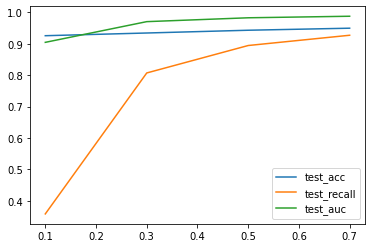

In [133]:
metric_df.plot.line()

In [87]:
# define the model
model = XGBClassifier(n_estimators=50)

#overfit the target label
over = SVMSMOTE(sampling_strategy=0.2)
X_res, y_res = over.fit_resample(X_imp_st, y)

# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)

#scoring params
scoring = {'acc': 'accuracy',
           'recall': 'recall',
           'auc': 'roc_auc'}

# evaluate the model on the dataset
n_scores = cross_validate(model, X_res, y_res, scoring=scoring, cv=cv, n_jobs=-1, return_train_score= False)

# report performance
for key, value in n_scores.items():
    print(key, mean(value))

fit_time 17.644864857196808
score_time 0.06098431348800659
test_acc 0.9464045203983634
test_recall 0.7930042735042735
test_auc 0.9715686590549314


In [74]:
# define the model
model = XGBClassifier(n_estimators=50)

#overfit the target label
over = BorderlineSMOTE(sampling_strategy=0.3)
X_res, y_res = over.fit_resample(X_imp, y)

# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)

#scoring params
scoring = {'acc': 'accuracy',
           'recall': 'recall',
           'auc': 'roc_auc'}

# evaluate the model on the dataset
n_scores = cross_validate(model, X_res, y_res, scoring=scoring, cv=cv, n_jobs=-1, return_train_score= False)

# report performance
for key, value in n_scores.items():
    print(key, mean(value))

fit_time 20.462152087688445
score_time 0.07071489095687866
test_acc 0.9350223404606114
test_recall 0.8156720477664751
test_auc 0.9714331789230787


In [75]:

# define the model
model = XGBClassifier(n_estimators=50)

#overfit the target label
over = ADASYN(sampling_strategy=0.3)
X_res, y_res = over.fit_resample(X_imp, y)

# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)

#scoring params
scoring = {'acc': 'accuracy',
           'recall': 'recall',
           'auc': 'roc_auc'}

# evaluate the model on the dataset
n_scores = cross_validate(model, X_res, y_res, scoring=scoring, cv=cv, n_jobs=-1, return_train_score= False)

# report performance
for key, value in n_scores.items():
    print(key, mean(value))

fit_time 25.17716989517212
score_time 0.10999076366424561
test_acc 0.9348383722280594
test_recall 0.8225130777806362
test_auc 0.9743761433121435


Feature engineering

In [128]:
model = XGBClassifier(n_estimators=50)
m = model.fit(X_imp, y)
zip_iterator = zip(list(X_imp.columns), m.feature_importances_)
feature_dict = dict(zip_iterator)
feature_dict

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[01:17:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'LeagueInvolved': 0.067118734,
 'CorrMarketValue': 0.08946462,
 'Age': 0.020768736,
 'Country': 0.037343197,
 'Position': 0.015360456,
 'Foot': 0.025663506,
 'IntReputation': 0.017990874,
 'Crossing': 0.014249209,
 'Finishing': 0.016765617,
 'Heading_accuracy': 0.016924214,
 'Short_passing': 0.015888643,
 'Volleys': 0.016110197,
 'Dribbling': 0.0157936,
 'Curve': 0.015834494,
 'FK_accuracy': 0.012066446,
 'Long_passing': 0.016167467,
 'Ball_control': 0.015590802,
 'Acceleration': 0.013054718,
 'Sprint_speed': 0.014245867,
 'Agility': 0.013111219,
 'Reactions': 0.012711993,
 'Balance': 0.015764054,
 'Shot_power': 0.013531177,
 'Jumping': 0.016211119,
 'Stamina': 0.015930336,
 'Strength': 0.012710304,
 'Long_shots': 0.015892388,
 'Aggression': 0.011847685,
 'Interceptions': 0.014161402,
 'Positioning': 0.011976618,
 'Vision': 0.012290878,
 'Penalties': 0.013726618,
 'Composure': 0.013586591,
 'Marking': 0.015367403,
 'Standing_tackle': 0.014867902,
 'Sliding_tackle': 0.015652124,
 'GK_d

In [129]:
dict( sorted(feature_dict.items(), key=operator.itemgetter(1),reverse=True))

{'CorrMarketValue': 0.08946462,
 'LeagueInvolved': 0.067118734,
 'DEGREE': 0.047757756,
 'Country': 0.037343197,
 'IT_SERIE_A': 0.037181742,
 'EN_PL': 0.03505361,
 'GE_BUNDESLIGA': 0.025696134,
 'Foot': 0.025663506,
 'FR_LIGUE_1': 0.025598852,
 'SP_LA_LIGA': 0.022171857,
 'Age': 0.020768736,
 'Eigv': 0.01905091,
 'GK_positioning': 0.018347744,
 'IntReputation': 0.017990874,
 'Heading_accuracy': 0.016924214,
 'GK_kicking': 0.016766505,
 'Finishing': 0.016765617,
 'Jumping': 0.016211119,
 'Long_passing': 0.016167467,
 'Volleys': 0.016110197,
 'Years': 0.016059084,
 'Stamina': 0.015930336,
 'Long_shots': 0.015892388,
 'Short_passing': 0.015888643,
 'Curve': 0.015834494,
 'Dribbling': 0.0157936,
 'Balance': 0.015764054,
 'Sliding_tackle': 0.015652124,
 'GK_reflexes': 0.015605179,
 'Ball_control': 0.015590802,
 'Marking': 0.015367403,
 'Position': 0.015360456,
 'Standing_tackle': 0.014867902,
 'Crossing': 0.014249209,
 'Sprint_speed': 0.014245867,
 'Interceptions': 0.014161402,
 'Penalties'

In [154]:
# define the model
model = XGBClassifier(n_estimators=50)

rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=40)
pipeline = Pipeline(steps=[('s',rfe),('m',model)])

# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)

#scoring params
scoring = {'acc': 'accuracy',
           'recall': 'recall',
           'auc': 'roc_auc'}

# evaluate the model on the dataset
n_scores = cross_validate(pipeline, X_imp, y, scoring=scoring, cv=cv, n_jobs=-1, return_train_score= False)

# report performance
for key, value in n_scores.items():
    print(key, mean(value))

fit_time 44.78804522752762
score_time 0.12960200309753417
test_acc 0.9257358069236318
test_recall 0.35240869144561804
test_auc 0.9032457839546767


In [140]:
# define the model with default hyperparameters
model = XGBClassifier()
# define the grid of values to search
grid = dict()
grid['n_estimators'] = [500]
grid['learning_rate'] = [0.01, 0.1, 1.0]
grid['subsample'] = [0.4, 0.7, 1]
#grid['max_features'] = [10, 20, 30]
grid['max_depth'] = [6, 9, 12]
#scoring params
scoring = {'acc': 'accuracy',
           'recall': 'recall',
           'auc': 'roc_auc'}
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=scoring, refit='auc')
# execute the grid search
grid_result = grid_search.fit(X_imp, y)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[06:16:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: 0.915625 using {'learning_rate': 0.01, 'max_depth': 12, 'n_estimators': 500, 'subsample': 0.7}


In [141]:
#create df for metrics
columns= ['params', 'mean_test_acc', 'mean_test_recall', 'mean_test_auc']
indexes = [x for x in range(27)]
metric_df = pd.DataFrame(index = indexes, columns=columns)
metric_df = metric_df.fillna(0)
metric_df['params'] = metric_df['params'].astype(str)
metric_df[['mean_test_acc', 'mean_test_recall', 'mean_test_auc']] = metric_df[['mean_test_acc', 'mean_test_recall', 'mean_test_auc']].astype(float)

metric_df['params'] = grid_result.cv_results_['params']
metric_df['mean_test_acc'] = grid_result.cv_results_['mean_test_acc']
metric_df['mean_test_recall'] = grid_result.cv_results_['mean_test_recall']
metric_df['mean_test_auc'] = grid_result.cv_results_['mean_test_auc']

metric_df

,params,mean_test_acc,mean_test_recall,mean_test_auc
0,"{'learning_rate': 0.01, 'max_depth': 6, 'n_est...",0.927342,0.308409,0.910065
1,"{'learning_rate': 0.01, 'max_depth': 6, 'n_est...",0.927285,0.306829,0.911585
2,"{'learning_rate': 0.01, 'max_depth': 6, 'n_est...",0.926396,0.299534,0.908115
3,"{'learning_rate': 0.01, 'max_depth': 9, 'n_est...",0.928117,0.318866,0.912465
4,"{'learning_rate': 0.01, 'max_depth': 9, 'n_est...",0.928633,0.331216,0.914968
5,"{'learning_rate': 0.01, 'max_depth': 9, 'n_est...",0.928317,0.341974,0.911415
6,"{'learning_rate': 0.01, 'max_depth': 12, 'n_es...",0.928404,0.316006,0.913027
7,"{'learning_rate': 0.01, 'max_depth': 12, 'n_es...",0.929666,0.337541,0.915625
8,"{'learning_rate': 0.01, 'max_depth': 12, 'n_es...",0.928920,0.351473,0.911197
9,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti...",0.925908,0.369844,0.904756


In [144]:
#Check the model with standardization
max_features = [22, 25, 28]
for m in max_features:
    # define the model
    model = XGBClassifier(n_estimators=500, subsample=0.7, max_depth=6, learning_rate=0.1, max_features = m)

    # define the evaluation method
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)

    #scoring params
    scoring = {'acc': 'accuracy',
            'recall': 'recall',
            'auc': 'roc_auc'}

    # evaluate the model on the dataset
    n_scores = cross_validate(model, X_imp_st, y, scoring=scoring, cv=cv, n_jobs=-1, return_train_score= False)

    # report performance
    for key, value in n_scores.items():
        print(m)
        print(key, mean(value))

22
fit_time 144.68603231906891
22
score_time 0.21292335987091066
22
test_acc 0.9282027520304021
22
test_recall 0.37269209062323627
22
test_auc 0.9097549472808313
25
fit_time 131.1722374200821
25
score_time 0.13515927791595458
25
test_acc 0.9282027520304021
25
test_recall 0.37269209062323627
25
test_auc 0.9097549472808313
28
fit_time 119.0152749657631
28
score_time 0.154928719997406
28
test_acc 0.9282027520304021
28
test_recall 0.37269209062323627
28
test_auc 0.9097549472808313


In [142]:
metric_df.to_excel('/Scripts/transfer_modelling/grid_search_result.xlsx')

In [88]:
model = XGBClassifier(n_estimators=500, subsample=0.7, max_depth=6, learning_rate=0.1)

#fit the model
m = model.fit(X_res, y_res)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[16:19:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [90]:
# load predict df
predict_df = pd.read_excel('/Scripts/5_transfer_modelling_datas/players_2021_predict_df3.xlsx')

#save the names to a df and drop it from the predict df
name_df = predict_df[['Name','ID', 'Country', 'LeagueInvolved']]

#drop the unnecessary column
predict_df = predict_df.drop(['Unnamed: 0','Pos', 'MarketValue', 'ID',\
    'Joined', 'Nationality', 'Name', 'Eigv'], 1)

#copy predict df
p_df = predict_df.copy()

#encode
p_df_cbe = cbe_encoder.transform(p_df)

#impute
p_df_cbe_imp = imputer.transform(p_df_cbe)
p_df_cbe_imp = pd.DataFrame(data = p_df_cbe_imp, columns = p_df_cbe.columns)

#standardization
p_df_cbe_imp_st = scaler.transform(p_df_cbe_imp)
p_df_cbe_imp_st = pd.DataFrame(data = p_df_cbe_imp_st, columns = p_df_cbe_imp.columns)

#predict 
#p_df_cbe_imp_st['preds'] = ml.predict(p_df_cbe_imp_st)
p_df_cbe_imp_st['confidence'] = m.predict_proba(p_df_cbe_imp_st)[:, 1]

#add the name column
p_df_cbe_imp_st['Name'] = name_df['Name']
p_df_cbe_imp_st['ID'] = name_df['ID']
p_df_cbe_imp_st['Country'] = name_df['Country']
p_df_cbe_imp_st['LeagueInvolved'] = name_df['LeagueInvolved']

#save the result in excel
#p_df_cbe_imp_st.to_excel('/Scripts/5_transfer_modelling_scripts/result_pl.xlsx')
p_df_cbe_imp_st.to_excel('/Scripts/5_transfer_modelling_scripts/result_laliga.xlsx')
#p_df_cbe_imp_st.to_excel('/Scripts/5_transfer_modelling_scripts/result_seriea.xlsx')
#p_df_cbe_imp_st.to_excel('/Scripts/5_transfer_modelling_scripts/result_ligue1.xlsx')
#p_df_cbe_imp_st.to_excel('/Scripts/5_transfer_modelling_scripts/result_bundesliga.xlsx')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


'English Premier League'

In [219]:
tdf['target'].value_counts()

0    15852
1     1579
Name: target, dtype: int64

In [220]:
# define the model
model = XGBClassifier(n_estimators=500, subsample=0.7, max_depth=6, learning_rate=0.1)

# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)

#scoring params
scoring = {'acc': 'accuracy',
           'recall': 'recall',
           'auc': 'roc_auc'}

# evaluate the model on the dataset
n_scores = cross_validate(model, X_imp_st, y, scoring=scoring, cv=cv, n_jobs=-1, return_train_score= False)

# report performance
for key, value in n_scores.items():
    print(key, mean(value))

fit_time 116.34197583198548
score_time 0.130845844745636
test_acc 0.9282027520304021
test_recall 0.37269209062323627
test_auc 0.9097549472808313


In [221]:
m = model.fit(X_imp_st, y)
zip_iterator = zip(list(X_imp_st.columns), m.feature_importances_)
feature_dict = dict(zip_iterator)
dict( sorted(feature_dict.items(), key=operator.itemgetter(1),reverse=True))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[13:30:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'EN_PL': 0.07543064,
 'CorrMarketValue': 0.061069876,
 'LeagueInvolved': 0.04448992,
 'IT_SERIE_A': 0.03602741,
 'DEGREE': 0.031983297,
 'Country': 0.030884247,
 'Age': 0.024595967,
 'Foot': 0.024302423,
 'GE_BUNDESLIGA': 0.023643972,
 'SP_LA_LIGA': 0.022218918,
 'FR_LIGUE_1': 0.020783553,
 'GK_kicking': 0.01913462,
 'Eigv': 0.019085083,
 'Stamina': 0.01799486,
 'IntReputation': 0.017629972,
 'Standing_tackle': 0.01747269,
 'Sliding_tackle': 0.017391978,
 'Heading_accuracy': 0.017087363,
 'Finishing': 0.01697355,
 'Reactions': 0.016884675,
 'Balance': 0.01687092,
 'Long_shots': 0.016638786,
 'GK_reflexes': 0.016548378,
 'Curve': 0.016445864,
 'Volleys': 0.016346978,
 'Dribbling': 0.016232932,
 'Interceptions': 0.016156266,
 'Strength': 0.016108893,
 'Acceleration': 0.016032461,
 'Marking': 0.015688732,
 'Long_passing': 0.01563273,
 'Short_passing': 0.015542802,
 'GK_positioning': 0.015412816,
 'GK_diving': 0.015354708,
 'Composure': 0.015225076,
 'Crossing': 0.015208019,
 'Penalties':

Spain Primera Division

In [206]:
tdf['target'].value_counts()

0    16249
1     1182
Name: target, dtype: int64

In [207]:
# define the model
model = XGBClassifier(n_estimators=500, subsample=0.7, max_depth=6, learning_rate=0.1)

# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)

#scoring params
scoring = {'acc': 'accuracy',
           'recall': 'recall',
           'auc': 'roc_auc'}

# evaluate the model on the dataset
n_scores = cross_validate(model, X_imp_st, y, scoring=scoring, cv=cv, n_jobs=-1, return_train_score= False)

# report performance
for key, value in n_scores.items():
    print(key, mean(value))

fit_time 163.75419728755952
score_time 0.28051395416259767
test_acc 0.9455280657360767
test_recall 0.3490065517732516
test_auc 0.9171168121683777


In [208]:
m = model.fit(X_imp_st, y)
zip_iterator = zip(list(X_imp_st.columns), m.feature_importances_)
feature_dict = dict(zip_iterator)
dict( sorted(feature_dict.items(), key=operator.itemgetter(1),reverse=True))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[13:14:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'SP_LA_LIGA': 0.081781134,
 'Country': 0.06022952,
 'LeagueInvolved': 0.041736595,
 'CorrMarketValue': 0.031127911,
 'IT_SERIE_A': 0.026895177,
 'DEGREE': 0.025577426,
 'IntReputation': 0.024735317,
 'Foot': 0.02261051,
 'FR_LIGUE_1': 0.021728063,
 'Sliding_tackle': 0.020842126,
 'Reactions': 0.02011249,
 'GE_BUNDESLIGA': 0.019937873,
 'Short_passing': 0.019676719,
 'Interceptions': 0.019131422,
 'EN_PL': 0.019030012,
 'Standing_tackle': 0.018938126,
 'Age': 0.01867156,
 'Curve': 0.018598838,
 'Ball_control': 0.01842062,
 'Eigv': 0.017963065,
 'Finishing': 0.017772771,
 'Marking': 0.017616745,
 'Vision': 0.017456511,
 'GK_kicking': 0.01723767,
 'Volleys': 0.017135933,
 'FK_accuracy': 0.017127067,
 'Jumping': 0.01698601,
 'Position': 0.016961647,
 'Crossing': 0.016855936,
 'Dribbling': 0.016316967,
 'Long_shots': 0.016302647,
 'Balance': 0.015662659,
 'Positioning': 0.01546647,
 'Composure': 0.01546164,
 'Agility': 0.015253614,
 'Penalties': 0.015161349,
 'GK_diving': 0.015156563,
 'Lo

Italian Serie A

In [194]:
tdf['target'].value_counts()

0    15469
1     1962
Name: target, dtype: int64

In [195]:
# define the model
model = XGBClassifier(n_estimators=500, subsample=0.7, max_depth=6, learning_rate=0.1)

# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)

#scoring params
scoring = {'acc': 'accuracy',
           'recall': 'recall',
           'auc': 'roc_auc'}

# evaluate the model on the dataset
n_scores = cross_validate(model, X_imp_st, y, scoring=scoring, cv=cv, n_jobs=-1, return_train_score= False)

# report performance
for key, value in n_scores.items():
    print(key, mean(value))

fit_time 165.51407358646392
score_time 0.17943907976150514
test_acc 0.9369228716964846
test_recall 0.5619354086812389
test_auc 0.9377928128114753


In [196]:
m = model.fit(X_imp_st, y)
zip_iterator = zip(list(X_imp_st.columns), m.feature_importances_)
feature_dict = dict(zip_iterator)
dict( sorted(feature_dict.items(), key=operator.itemgetter(1),reverse=True))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[12:53:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'IT_SERIE_A': 0.25747466,
 'LeagueInvolved': 0.041223347,
 'Country': 0.027814338,
 'CorrMarketValue': 0.026312975,
 'Foot': 0.023971107,
 'DEGREE': 0.023633806,
 'Eigv': 0.02290062,
 'SP_LA_LIGA': 0.021745728,
 'Age': 0.020525174,
 'Ball_control': 0.019879373,
 'Sliding_tackle': 0.018117588,
 'GK_kicking': 0.015469994,
 'IntReputation': 0.015168412,
 'Interceptions': 0.015054775,
 'Vision': 0.015006033,
 'Finishing': 0.01489244,
 'Composure': 0.014476631,
 'GK_handling': 0.014393425,
 'GK_reflexes': 0.014356014,
 'Dribbling': 0.01431823,
 'GE_BUNDESLIGA': 0.014111714,
 'Stamina': 0.01390391,
 'FR_LIGUE_1': 0.013812639,
 'Long_passing': 0.013676626,
 'Short_passing': 0.013611804,
 'Positioning': 0.013378849,
 'Marking': 0.0133099,
 'GK_positioning': 0.013305962,
 'Long_shots': 0.013206923,
 'Crossing': 0.013082646,
 'Acceleration': 0.013040155,
 'Curve': 0.0130376555,
 'Volleys': 0.01302334,
 'Years': 0.012925279,
 'Agility': 0.012611002,
 'Reactions': 0.01235738,
 'Standing_tackle': 

French Ligue 1

In [233]:
tdf['target'].value_counts()

0    16274
1     1157
Name: target, dtype: int64

In [234]:
# define the model
model = XGBClassifier(n_estimators=500, subsample=0.7, max_depth=6, learning_rate=0.1)

# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)

#scoring params
scoring = {'acc': 'accuracy',
           'recall': 'recall',
           'auc': 'roc_auc'}

# evaluate the model on the dataset
n_scores = cross_validate(model, X_imp_st, y, scoring=scoring, cv=cv, n_jobs=-1, return_train_score= False)

# report performance
for key, value in n_scores.items():
    print(key, mean(value))

fit_time 143.9721603512764
score_time 0.1668903946876526
test_acc 0.9457575715706865
test_recall 0.34788980509745127
test_auc 0.8997180921487506


In [235]:
m = model.fit(X_imp_st, y)
zip_iterator = zip(list(X_imp_st.columns), m.feature_importances_)
feature_dict = dict(zip_iterator)
dict( sorted(feature_dict.items(), key=operator.itemgetter(1),reverse=True))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[13:49:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'LeagueInvolved': 0.060094733,
 'FR_LIGUE_1': 0.045711055,
 'Country': 0.04563606,
 'Years': 0.028469516,
 'EN_PL': 0.0277901,
 'DEGREE': 0.026452733,
 'CorrMarketValue': 0.024872076,
 'Foot': 0.023949454,
 'Age': 0.023358941,
 'Eigv': 0.022893112,
 'Short_passing': 0.022257077,
 'IntReputation': 0.02057262,
 'Ball_control': 0.020223293,
 'SP_LA_LIGA': 0.019920422,
 'Reactions': 0.019110046,
 'Finishing': 0.019058067,
 'Sliding_tackle': 0.018945863,
 'Heading_accuracy': 0.018727984,
 'IT_SERIE_A': 0.018389484,
 'GE_BUNDESLIGA': 0.018375529,
 'GK_handling': 0.018198812,
 'GK_positioning': 0.017796583,
 'Shot_power': 0.017761823,
 'Volleys': 0.01775072,
 'GK_kicking': 0.017713748,
 'Standing_tackle': 0.017672623,
 'Strength': 0.01741032,
 'Marking': 0.01739297,
 'Agility': 0.01734571,
 'Jumping': 0.01721168,
 'Curve': 0.017016992,
 'Position': 0.016734155,
 'Penalties': 0.016680097,
 'Dribbling': 0.016672008,
 'Sprint_speed': 0.016607149,
 'FK_accuracy': 0.016486235,
 'Interceptions': 0

German 1 Bundesliga

In [256]:
tdf['target'].value_counts()

0    16133
1     1298
Name: target, dtype: int64

In [257]:
# define the model
model = XGBClassifier(n_estimators=500, subsample=0.7, max_depth=6, learning_rate=0.1)

# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)

#scoring params
scoring = {'acc': 'accuracy',
           'recall': 'recall',
           'auc': 'roc_auc'}

# evaluate the model on the dataset
n_scores = cross_validate(model, X_imp_st, y, scoring=scoring, cv=cv, n_jobs=-1, return_train_score= False)

# report performance
for key, value in n_scores.items():
    print(key, mean(value))

fit_time 123.90389186143875
score_time 0.15353232622146606
test_acc 0.9428603338649486
test_recall 0.38632081097197385
test_auc 0.9117620183963568


In [258]:
m = model.fit(X_imp_st, y)
zip_iterator = zip(list(X_imp_st.columns), m.feature_importances_)
feature_dict = dict(zip_iterator)
dict( sorted(feature_dict.items(), key=operator.itemgetter(1),reverse=True))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[14:08:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'GE_BUNDESLIGA': 0.12035412,
 'LeagueInvolved': 0.043231204,
 'CorrMarketValue': 0.034268774,
 'Age': 0.029035537,
 'Country': 0.0286622,
 'Eigv': 0.025652682,
 'DEGREE': 0.025011877,
 'IT_SERIE_A': 0.023430021,
 'Reactions': 0.022169547,
 'SP_LA_LIGA': 0.01976017,
 'IntReputation': 0.019552331,
 'Marking': 0.0188082,
 'Short_passing': 0.018754805,
 'Foot': 0.01802719,
 'Finishing': 0.018026782,
 'FR_LIGUE_1': 0.01790618,
 'Dribbling': 0.017813094,
 'Heading_accuracy': 0.017575424,
 'Standing_tackle': 0.017560741,
 'Sliding_tackle': 0.017342879,
 'Ball_control': 0.01734155,
 'Crossing': 0.01715598,
 'Curve': 0.016859196,
 'Long_shots': 0.016818339,
 'Positioning': 0.01661522,
 'Interceptions': 0.016559396,
 'Stamina': 0.016472029,
 'Sprint_speed': 0.016307656,
 'Composure': 0.01622056,
 'Shot_power': 0.01621705,
 'Position': 0.015889287,
 'GK_kicking': 0.015856588,
 'GK_reflexes': 0.01573061,
 'GK_positioning': 0.015624254,
 'Agility': 0.015525941,
 'Balance': 0.015514727,
 'Volleys':